In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping
import pdb
# # 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

### 导入数据

In [3]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df2 = df.copy(deep=True) 

In [4]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

### 缺失值填充

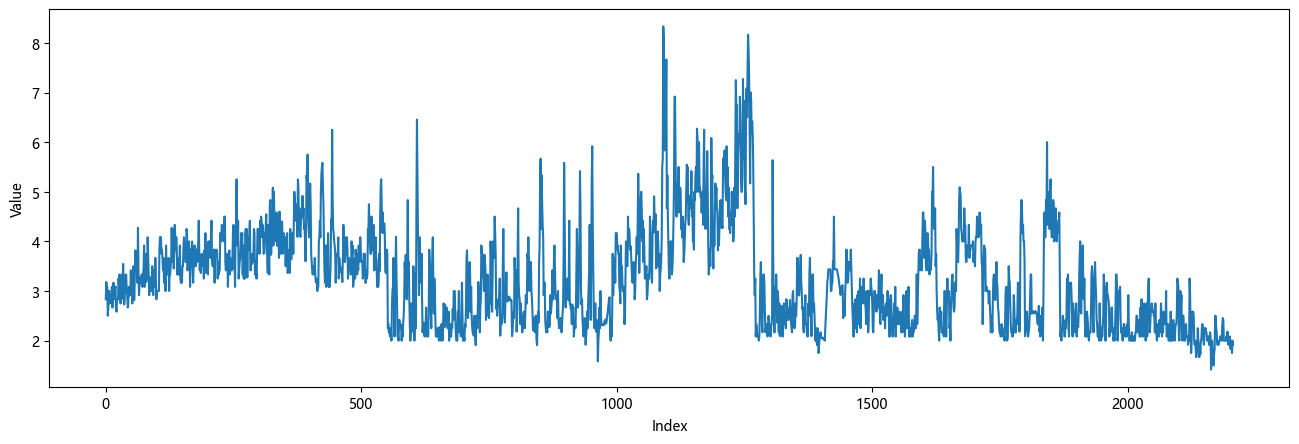

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df2["主机CPU平均负载"] = knn_mean(df2["主机CPU平均负载"], 24)
# df2["主机CPU平均负载"].astype(int)
plot_df(df2, x=df2.index, y= df2["主机CPU平均负载"], title='')

### 参数设置

In [6]:
# 平滑前,滞后阶数
num_hour = 336
learning_rate = 1e-3
epoch_n = 1000
h_size = 6

In [7]:
data_1 = df2["主机CPU平均负载"]
dataframe_1 = pd.DataFrame()
for i in range(num_hour-1,0,-1):
    dataframe_1['t-'+str(i)] = data_1.shift(i)
dataframe_1['t'] = data_1.values
for i in range(1,13):
    dataframe_1['t+'+str(i)] = data_1.shift(periods=-i, axis=0)

pd.set_option('display.max_columns', 16)
dataframe_1

,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,...,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.6667,3.0000,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167,3.1667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167,3.1667,2.8333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2203,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2204,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2205,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,2.0833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Loess Smoothing (5% and 15%)
# from statsmodels.nonparametric.smoothers_lowess import lowess
# plt.figure(figsize=(16,5), dpi=100)
# df_loess_5 = pd.DataFrame(lowess(df2["主机CPU平均负载"], np.arange(len(df2["主机CPU平均负载"])), frac=0.002)[:, 1], index=df2["主机CPU平均负载"].index, columns=['主机CPU平均负载'])
# plt.plot(df2["主机CPU平均负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_loess_5[100:200],label = '平滑曲线__frac=0.002',color = 'red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [9]:
# # 滞后阶数
# num_hour = 336
# data = df_loess_5["主机CPU平均负载"]
# dataframe = pd.DataFrame()
# for i in range(num_hour,0,-1):
#     dataframe['t-'+str(i)] = data.shift(i)
# dataframe['t'] = data.values
# dataframe

In [10]:
# all_data = dataframe_1[num_hour-1:-12]
# all_data

### 测试集和训练集

In [11]:
np.random.seed(2)
all_data = dataframe_1[num_hour-1:-12]
# all_data = shuffle(all_data)
# all_data.to_csv('shuffle_smooth.csv')
# pd.set_option('display.max_columns', 14)
# all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
# all_data["groud_truth"] = dataframe_1["t"]
all_data

,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,...,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
335,2.8333,3.1818,3.0833,3.0833,2.5000,2.6667,3.0000,3.0000,...,4.6000,3.9167,3.7500,3.9167,4.3333,4.4000,4.0833,3.7500
336,3.1818,3.0833,3.0833,2.5000,2.6667,3.0000,3.0000,2.7500,...,3.9167,3.7500,3.9167,4.3333,4.4000,4.0833,3.7500,4.1667
337,3.0833,3.0833,2.5000,2.6667,3.0000,3.0000,2.7500,2.9167,...,3.7500,3.9167,4.3333,4.4000,4.0833,3.7500,4.1667,4.0833
338,3.0833,2.5000,2.6667,3.0000,3.0000,2.7500,2.9167,2.9091,...,3.9167,4.3333,4.4000,4.0833,3.7500,4.1667,4.0833,4.0833
339,2.5000,2.6667,3.0000,3.0000,2.7500,2.9167,2.9091,2.8333,...,4.3333,4.4000,4.0833,3.7500,4.1667,4.0833,4.0833,4.0833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,4.7500,4.0000,4.5833,4.5000,4.6667,4.0833,4.0000,4.3333,...,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000
2191,4.0000,4.5833,4.5000,4.6667,4.0833,4.0000,4.3333,4.1667,...,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167
2192,4.5833,4.5000,4.6667,4.0833,4.0000,4.3333,4.1667,4.4167,...,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500
2193,4.5000,4.6667,4.0833,4.0000,4.3333,4.1667,4.4167,4.4167,...,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500,2.0000


In [12]:
# person = all_data.corr()
# indexSort = person.loc["t"].sort_values(ascending = False,inplace = False)
# index = indexSort[85:].index
# len(index)

In [13]:
# pd.set_option('display.max_columns', 13)
# person

In [14]:
# pd.set_option('display.max_columns', 14)
# for i in index:
#     del all_data[i]
# all_data

In [15]:
# all_data.iloc[0:var1,-12:]

In [16]:
var1 = int(len(all_data)*0.6)
var2 = int(len(all_data)*0.8)
train_data = all_data.iloc[0:var1]
train_truth = all_data.iloc[0:var1,-12:]
validate_data = all_data.iloc[var1:var2]
validate_truth = all_data.iloc[var1:var2,-12:]
test_data = all_data.iloc[var2:]
test_truth = all_data.iloc[var2:,-12:]
# train_data
# test_data
# validate_data

In [17]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

### 归一化

In [18]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,num_hour+12)
train_data_normalized.shape

(1116, 348)

In [19]:
validate_data_normalized = scaler.transform(validate_data.values.reshape(-1, 1))
validate_data_normalized = validate_data_normalized.reshape(-1,num_hour+12)
validate_data_normalized.shape

(372, 348)

In [20]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,num_hour+12)
test_data_normalized.shape

(372, 348)

In [22]:
train_X = torch.Tensor(train_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
train_Y = torch.Tensor(train_data_normalized[:,-12:].reshape(-1, 1, 12))
train_X.shape

torch.Size([1116, 1, 336])

In [24]:
validate_X = torch.Tensor(validate_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
validate_Y = torch.Tensor(validate_data_normalized[:,-12:].reshape(-1, 1, 12))
validate_X.shape

torch.Size([372, 1, 336])

In [25]:
test_X = torch.Tensor(test_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
test_Y = torch.Tensor(test_data_normalized[:,-12:].reshape(-1, 1, 12))
test_Y.shape

torch.Size([372, 1, 12])

In [26]:
# train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
# test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
# train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
# test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

### 建立VAE模型

In [27]:
start = time.time()

In [34]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
        nn.Linear(num_hour, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, h_size),
        nn.ReLU()
        )
        self.decoder = nn.Sequential(
        nn.Linear(int(h_size / 2), 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, num_hour),
        nn.Sigmoid()
        )

        self.criteon = nn.MSELoss()
        
    def forward(self, x):
        """
        :param x: [b, 1, 336]
        :return:
        """
        batchsz = x.size(0)
        # flatten
        x = x.view(batchsz, num_hour)
        # encoder
        h_ = self.encoder(x)
        # [b, 20] => [b, 10] and [b, 10]
        mu, sigma = h_.chunk(2, dim=1)
        # reparametrize trick, epison~N(0, 1)
        h = mu + sigma * torch.randn_like(sigma) # 914,10
        # decoder
        x_hat = self.decoder(h)
        # reshape
        x_hat = x_hat.view(batchsz, 1, num_hour)
        
        kld = 0.5 * torch.sum(
            torch.pow(mu, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (batchsz*num_hour)  
        return x_hat, kld, h
    
model_VAE = VAE()
model_VAE

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=336, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=336, bias=True)
    (5): Sigmoid()
  )
  (criteon): MSELoss()
)

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_VAE.parameters(), lr=learning_rate)
# patience = 100  
# early_stopping = EarlyStopping(patience, verbose=True)

In [36]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X)
#     var_y = Variable(train_Y)
    # 前向传播
    x_hat, kld, _ = model_VAE(var_x)
    loss = criterion(x_hat, var_x)
    
    if kld is not None:
        elbo = - loss - 1.0 * kld
        loss = - elbo
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f},kld: {:.5f}'.format(e, loss.item(),kld.item()))
    ep.append(e)
    losses.append(loss.item())

print('Finished Training') 

Epoch: 10, Loss: 0.07219,kld: 0.02718
Epoch: 20, Loss: 0.05566,kld: 0.02682
Epoch: 30, Loss: 0.05186,kld: 0.02745
Epoch: 40, Loss: 0.05145,kld: 0.02741
Epoch: 50, Loss: 0.04988,kld: 0.02627
Epoch: 60, Loss: 0.04934,kld: 0.02625
Epoch: 70, Loss: 0.04909,kld: 0.02621
Epoch: 80, Loss: 0.04907,kld: 0.02622
Epoch: 90, Loss: 0.04887,kld: 0.02623
Epoch: 100, Loss: 0.04906,kld: 0.02624
Epoch: 110, Loss: 0.04896,kld: 0.02625
Epoch: 120, Loss: 0.04893,kld: 0.02626
Epoch: 130, Loss: 0.04878,kld: 0.02628
Epoch: 140, Loss: 0.04880,kld: 0.02629
Epoch: 150, Loss: 0.04885,kld: 0.02631
Epoch: 160, Loss: 0.04887,kld: 0.02633
Epoch: 170, Loss: 0.04870,kld: 0.02636
Epoch: 180, Loss: 0.04865,kld: 0.02639
Epoch: 190, Loss: 0.04866,kld: 0.02643
Epoch: 200, Loss: 0.04837,kld: 0.02647
Epoch: 210, Loss: 0.04850,kld: 0.02652
Epoch: 220, Loss: 0.04852,kld: 0.02658
Epoch: 230, Loss: 0.04835,kld: 0.02665
Epoch: 240, Loss: 0.04860,kld: 0.02672
Epoch: 250, Loss: 0.04881,kld: 0.02678
Epoch: 260, Loss: 0.04847,kld: 0.0

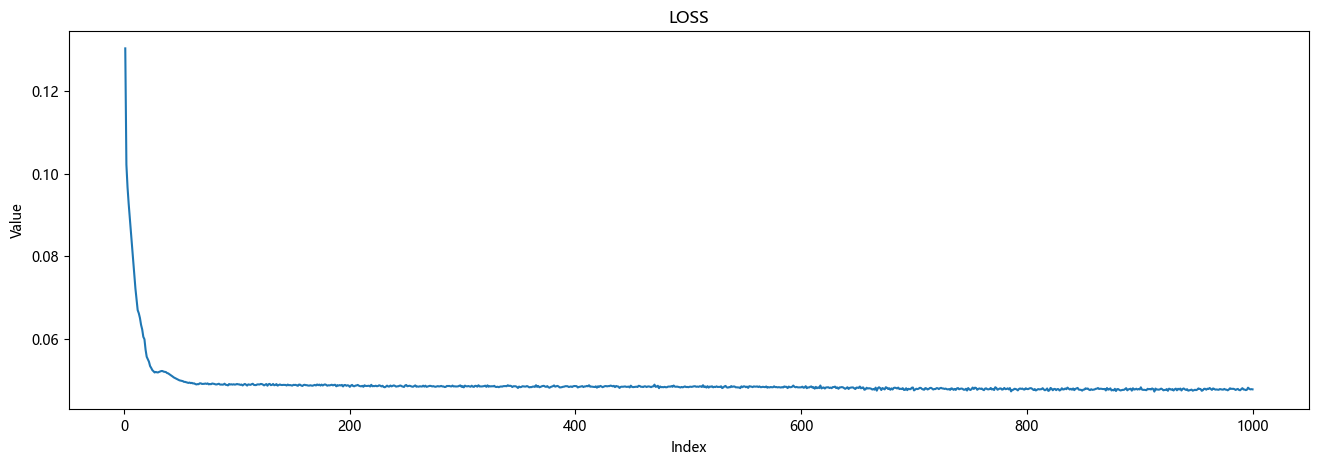

In [37]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [38]:
# pdb.set_trace()

In [39]:
torch.save(model_VAE, 'VAE_net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [40]:
model_VAE2 = torch.load('VAE_net.pkl')

In [41]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [42]:
outputs, kld, outputs_hat = model_VAE2(train_X)
train_X2 = outputs.reshape(-1,1,num_hour)
train_X2.shape

torch.Size([1116, 1, 336])

In [43]:
outputs, kld, outputs_hat = model_VAE2(validate_X)
validate_X2 = outputs.reshape(-1,1,num_hour)
validate_X2.shape

torch.Size([372, 1, 336])

In [44]:
outputs, kld, outputs_hat = model_VAE2(test_X)
test_X2 = outputs.reshape(-1,1,num_hour)
test_X2.shape

torch.Size([372, 1, 336])

### 建立LSTM模型

In [45]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True,dropout=0.5)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
#         x = x[:,[0],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model_lstm = lstm(num_hour, 128, 12, 2)
model_lstm

lstm(
  (layer1): LSTM(336, 128, num_layers=2, batch_first=True, dropout=0.5)
  (layer2): Linear(in_features=128, out_features=12, bias=True)
)

In [46]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-2)
epoch_n = 1000
# 初始化 early_stopping 对象
# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
patience = 40

# 关于 EarlyStopping 的代码可先看博客后面的内容
early_stopping = EarlyStopping(patience, verbose=True)

In [47]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X2)
    var_y = Variable(train_Y)
    # 前向传播
    out = model_lstm(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_output = model_lstm(validate_X2)
    valid_loss = criterion(valid_output, validate_Y)
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.8f}, VA_Loss: {:.8f}'.format(e, loss.item(), valid_loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
#     early_stopping(valid_loss, model_lstm)
    
#     # 若满足 early stopping 要求
#     if early_stopping.early_stop:
#         print("Early stopping")
#         # 结束模型训练
#         break
    
#     break
#     if (e+1)%120 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.1
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 10, Loss: 0.03554164, VA_Loss: 0.02433340
Epoch: 20, Loss: 0.02973955, VA_Loss: 0.01501547
Epoch: 30, Loss: 0.02851195, VA_Loss: 0.01742805
Epoch: 40, Loss: 0.02821190, VA_Loss: 0.01827827
Epoch: 50, Loss: 0.02793946, VA_Loss: 0.01690603
Epoch: 60, Loss: 0.02751594, VA_Loss: 0.01705716
Epoch: 70, Loss: 0.02641376, VA_Loss: 0.01702807
Epoch: 80, Loss: 0.02552042, VA_Loss: 0.01760328
Epoch: 90, Loss: 0.02510598, VA_Loss: 0.01737451
Epoch: 100, Loss: 0.02533862, VA_Loss: 0.01718126
Epoch: 110, Loss: 0.02549227, VA_Loss: 0.01810287
Epoch: 120, Loss: 0.02509542, VA_Loss: 0.01756108
Epoch: 130, Loss: 0.02490973, VA_Loss: 0.01664795
Epoch: 140, Loss: 0.02500372, VA_Loss: 0.01662861
Epoch: 150, Loss: 0.02536612, VA_Loss: 0.01713350
Epoch: 160, Loss: 0.02533562, VA_Loss: 0.01870067
Epoch: 170, Loss: 0.02508060, VA_Loss: 0.01658544
Epoch: 180, Loss: 0.02497072, VA_Loss: 0.01780800
Epoch: 190, Loss: 0.02501680, VA_Loss: 0.01723315
Epoch: 200, Loss: 0.02497116, VA_Loss: 0.01713530
Epoch: 21

In [48]:
# end = time.time()

In [49]:
# time = end - start
# print(f'运行时长为:{int(time)}s')

In [50]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

In [51]:
# plot_df(df, x=ep, y= losses, title='LOSS')

In [52]:
torch.save(model_lstm, 'net3.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [53]:
model_lstm2 = torch.load('net3.pkl')

### 验证测试集

In [54]:
# def rereal(list_temp, min_value, max_value):
#     arr = []
#     for dat in list_temp:
#         temp = dat*(max_value-min_value) + min_value
#         arr.append(temp)
#     return arr

In [55]:
outputs = model_lstm2(validate_X2)
loss = criterion(outputs, validate_Y)
loss

tensor(0.0177, grad_fn=<MseLossBackward>)

In [56]:
# outputs.shape

In [57]:
# num = len(test_Y)

In [58]:
# outputs = outputs.reshape(num,12)
# y_pred_temp = outputs.detach().numpy()
# tru_temp = test_Y.detach().numpy().reshape(num)

In [59]:
def com_test(arr1,arr2):
    MSEs = []
    errors = []
    MAPEs = []
    num_temp = len(arr1)
    
    for i in range(num_temp):
        error = abs(arr1[i] - arr2[i])
        errors.append(error)
        MSEs.append(error**2)
        MAPEs.append((error/arr2[i])*100)
    
    MSE = np.mean(MSEs)
    MAPE = np.mean(MAPEs)
    
    return MSE, MAPE, MAPEs, errors

def mape(y_true, y_pred):
    """
    参数:
    y_true -- 测试集目标真实值
    y_pred -- 测试集目标预测值
    
    返回:
    mape -- MAPE 评价指标
    """
    y_true = y_true.reshape(-1).detach().numpy()
    y_pred = y_pred.reshape(-1).detach().numpy()
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

In [60]:
predict = outputs*(max_value-min_value) + min_value
truth =  torch.Tensor(test_truth.values.reshape(-1, 1, 12))

In [61]:
# predict[0][0]

In [62]:
print(f"测试集整体MSE: {criterion(predict, truth)}")

测试集整体MSE: 1.5090194940567017


In [63]:
print(f"测试集整体MAPE: {mape(truth, predict)}")

测试集整体MAPE: 49.69755065506425


In [64]:
order = 270
# 10,120,200,230,270

In [65]:
from scipy.stats import norm
from collections import deque
const = norm.ppf(1 - 0.01 / 2.)
samples_in = deque(test_data.iloc[order, -50-12:-12].values)
forecast = predict[order][0].detach().numpy().tolist()
# a = 总体平均值 - Z*标准误差
top = []
bottom = []
for i in range(12):
    samples_std = np.std(samples_in,ddof=1)
    a = forecast[i] - const * (samples_std / np.sqrt(50))* np.sqrt(i+1)
    b = forecast[i] + const * (samples_std / np.sqrt(50))* np.sqrt(i+1)
    top.append(b)
    bottom.append(a)
    
    samples_in.popleft()
    samples_in.append(forecast[i])

ValueError: x and y must have same first dimension, but have shapes (684,) and (348,)

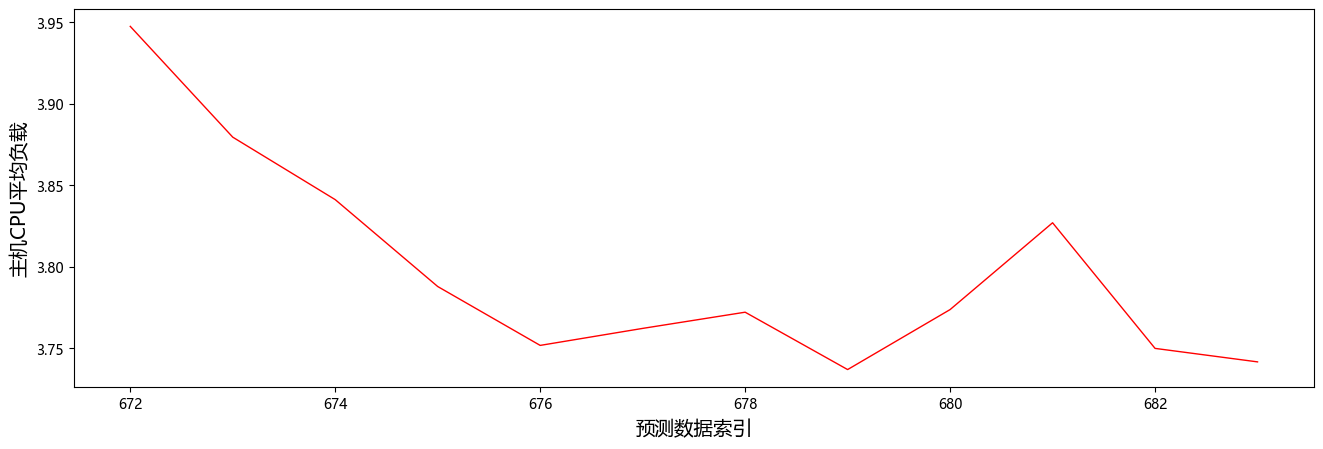

In [66]:
# 还原归一化
pre = predict[order][0].detach().numpy().tolist()
tru = test_data.iloc[order, :].values.tolist()
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"主机CPU平均负载", fontsize=14)
plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
plt.plot(range(672+12), tru, c='blue', lw='1',label="真实值")
plt.fill_between(range(672, 672+12),top,bottom,color='blue',alpha=0.05)
plt.legend(loc='best')

In [ ]:
# 还原归一化
pre = predict[order][0].detach().numpy().tolist()
tru = test_data.iloc[order, :].values.tolist()
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"主机CPU平均负载", fontsize=14)
plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
plt.plot(range(672-24, 672+12), tru[-12-24:], c='blue', lw='1',label="真实值")
plt.ylim(1,6)
plt.fill_between(range(672, 672+12),top,bottom,color='blue',alpha=0.05)
plt.legend(loc='best')

In [ ]:
MSE, MAPE, MAPEs, errors = com_test(pre, tru[-12:])
print(f"第一行MSE:   {round(MSE, 4)}\n第一行MAPE:  {round(MAPE, 2)}%")

In [ ]:
# 求真实值与预测值的误差值
num = len(errors)
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"绝对误差", fontsize=14)
plt.plot(range(num), errors, c='blue', lw='1')
plt.ylim(0,2)
plt.legend(loc='best')

In [ ]:
# 求真实值与预测值的误差值占原真实值的百分比
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"绝对误差百分比", fontsize=14)
plt.plot(range(num), MAPEs, c='blue', lw='1')
plt.legend(loc='best')

### 验证训练集

In [ ]:
outputs = model_lstm2(train_X2)
loss = criterion(outputs, train_Y)
loss

In [ ]:
predict2 = outputs*(max_value-min_value) + min_value
truth2 =  torch.Tensor(train_truth.values.reshape(-1, 1, 12))

In [ ]:
print(f"训练集整体MSE: {criterion(predict2, truth2)}")

In [ ]:
print(f"训练集整体MAPE: {mape(truth2, predict2)}")

In [ ]:
# # 还原归一化
# pre = predict[0][0].detach().numpy().tolist()
# tru = train_data.iloc[0, :].values.tolist()
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"主机CPU平均负载", fontsize=14)
# plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
# plt.plot(range(672+12), tru, c='blue', lw='1',label="真实值")
# plt.legend(loc='best')

In [ ]:
# MSE, MAPE, MAPEs, errors = com_test(pre, tru[-12:])
# print(f"MSE:   {round(MSE, 4)}\nMAPE:  {round(MAPE, 2)}%")

In [ ]:
# # 求真实值与预测值的误差值
# errors = []
# for i in range(num):
#     error = abs(truth[i] - predict[i])
#     errors.append(error)
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"绝对误差", fontsize=14)
# plt.plot(range(num), errors, c='blue', lw='1')
# plt.ylim(0,3)
# plt.legend(loc='best')

In [ ]:
# # 求真实值与预测值的误差值占原真实值的百分比
# errors_p = []
# for i in range(num):
#     error = ((abs(truth[i] - predict[i]))/truth[i])*100
#     errors_p.append(error)
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"绝对误差百分比", fontsize=14)
# plt.plot(range(num), errors_p, c='blue', lw='1')
# plt.ylim(0,70)
# plt.legend(loc='best')

In [ ]:
# mean(errors_p)